# **Consumer Analytical Profile Analysis (LDP) for 3 Months Interactions**

In [2]:
%run bi_feature_eng_utilities.ipynb 
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions/tables

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


  Using cached https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
  Using cached https://files.pythonhosted.org/packages/08/95/e1e457e5954d34136b9c63d3bc535da582501eb5c8b8a689c706bd3d4585/boto3-1.9.200-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a8/e3/e31d91b4550b93f17bc4180f07b3deabc6e29c19972d9a1e6c71acac56e9/botocore-1.12.200-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e6/60/247f

In [38]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing

# Random Sample input data if too large this number should be presented as integer ]0,100]
sample_rate_percentage = 100

s3 = s3fs.S3FileSystem()

In [4]:
# It runs k-mean for up to up_to_max_cluster_number ()
def run_k_mean(df, up_to_max_cluster_number, title):
    distortions = []
    for i in range(1, up_to_max_cluster_number):
        print('iteration {}'.format(i))
        km = KMeans(
            n_clusters=i, 
            init='random',
            n_init=10, 
            max_iter=300,
            tol=1e-04, 
            random_state=0,
            n_jobs=multiprocessing.cpu_count()-2 
        )
        km.fit(df)
        distortions.append(km.inertia_)

    df_labels = km.predict(df)
    df_centroids = km.cluster_centers_

    # plot number of clusters against distoration to find optimal number of clusters for 
    plt.plot(range(1, up_to_max_cluster_number), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title(title)
    plt.show()

    return (df_labels, df_centroids, distortions )

In [5]:
user_interactions_db_handler= FeatureEngineeringUtilities(db_name= 'buyer_intent_user_interactions', 
                                                          db_path_on_s3 = 's3://datascience-workspace-dev/buyer-intent/user_interactions', 
                                                          logger_name = 'buyer_intent')

2019-08-05 17:09:41.018 INFO athena_util.py.111 - Read config from default schema
2019-08-05 17:09:41.019 INFO athena_util.py.114 - Schema fetched from default config file:


In [6]:
user_interactions_db_handler.drop_table('biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(
                                                                    str(int((100/sample_rate_percentage)*100))))
user_interactions_db_handler.random_sample_based_on_string_attr(from_table_name = 'biui_consumer_analytical_profile_summary_t180',
                                                                to_table_name = 'biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(
                                                                    str(int((100/sample_rate_percentage)*100))),
                                                                sample_rate = int(100/sample_rate_percentage),
                                                                string_atr = 'member_id',
                                                                extr_loc_by_table_name = True)

2019-08-05 17:09:41.920 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-05 17:09:42.072 INFO athena_util.py.462 - 2019-08-05 17:09:42.072750
2019-08-05 17:09:43.661 INFO athena_util.py.464 - 2019-08-05 17:09:43.661777
2019-08-05 17:09:43.730 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-05 17:09:43.799 INFO athena_util.py.462 - 2019-08-05 17:09:43.799333
2019-08-05 17:10:05.892 INFO athena_util.py.464 - 2019-08-05 17:10:05.892869


0

In [7]:
res = user_interactions_db_handler.get_table_size('biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(
    str(int((100/sample_rate_percentage)*100))))
print(res)

2019-08-05 17:10:18.660 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-05 17:10:18.809 INFO athena_util.py.462 - 2019-08-05 17:10:18.809534
2019-08-05 17:10:21.942 INFO athena_util.py.464 - 2019-08-05 17:10:21.942054
37595807


In [8]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions/tables/{}'.format(
    'biui_sampled_{}_consumer_analytical_profile_summary_t180'.format(str(int((100/sample_rate_percentage)*100))))
print(s3_data_path)

s3://datascience-workspace-dev/buyer-intent/user_interactions/tables/biui_sampled_100_consumer_analytical_profile_summary_t180


In [9]:
df = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()

## **Basic Statistical Analysis : Dimension Reduction**

In [10]:
#Clean up non-numeric variables for k-mean
df = df.drop(columns=['snapshot_date_mst_yyyymmdd','member_id','most_recent_ldp_visit_date', 'ldp_dominant_zip'])

In [10]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['not for sale' 'for sale' 'no_segment' 'for rent']


In [11]:
unique_number_of_segments = len(unique_segments)
print(unique_number_of_segments)

4


In [12]:
#Filter based on different segments
unique_segments = df['ldp_dominant_segment'].unique()
print(unique_segments)

['not for sale' 'for sale' 'no_segment' 'for rent']


### Now Partition Based on different Segments like : ['for sale' 'not for sale' 'no_segment' 'for rent']

In [11]:
df_for_sale = df.loc[df['ldp_dominant_segment'] == 'for sale']
df_no_segment = df.loc[df['ldp_dominant_segment'] == 'no_segment']
df_not_for_sale = df.loc[df['ldp_dominant_segment'] == 'not for sale']
df_for_rent = df.loc[df['ldp_dominant_segment'] == 'for rent']

In [48]:
#Get correlation matrix for possible dimension reduction
corr_df_for_sale = df_for_sale.corr()
corr_df_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0621559,0.310482,0.0334925,0.832355,-0.0638853,-0.0616148,0.460072,0.916579,0.923519,0.916579,0.916579,0.923519,0.923519
median_ldp_page_views,0.0621559,1,0.694323,0.274666,0.0361108,0.327982,0.188582,0.0698882,-0.0179103,-0.0157463,-0.0179103,-0.0179103,-0.0157463,-0.0157463
average_ldp_page_views,0.310482,0.694323,1,0.383004,0.303815,0.17816,0.0774828,0.412977,0.149969,0.155877,0.149969,0.149969,0.155877,0.155877
average_ldp_dwell_time_seconds,0.0334925,0.274666,0.383004,1,0.178115,0.739616,0.559458,0.421159,-0.0192193,-0.0185012,-0.0192193,-0.0192193,-0.0185012,-0.0185012
total_ldp_dwell_time_seconds,0.832355,0.0361108,0.303815,0.178115,1,-0.0174144,-0.0616482,0.620253,0.773362,0.779029,0.773362,0.773362,0.779029,0.779029
median_ldp_dwell_time_seconds,-0.0638853,0.327982,0.17816,0.739616,-0.0174144,1,0.676088,0.0287343,-0.0815732,-0.082459,-0.0815732,-0.0815732,-0.082459,-0.082459
minimum_ldp_dwell_time_seconds,-0.0616148,0.188582,0.0774828,0.559458,-0.0616482,0.676088,1,-0.0430747,-0.0697215,-0.0705767,-0.0697215,-0.0697215,-0.0705767,-0.0705767
maximum_ldp_dwell_time_seconds,0.460072,0.0698882,0.412977,0.421159,0.620253,0.0287343,-0.0430747,1,0.379463,0.384054,0.379463,0.379463,0.384054,0.384054
total_distinct_listings_viewed,0.916579,-0.0179103,0.149969,-0.0192193,0.773362,-0.0815732,-0.0697215,0.379463,1,0.99718,1,1,0.99718,0.99718
total_listings_viewed,0.923519,-0.0157463,0.155877,-0.0185012,0.779029,-0.082459,-0.0705767,0.384054,0.99718,1,0.99718,0.99718,1,1


In [50]:
corr_df_no_segment = df_no_segment.corr()
corr_df_no_segment.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0235914,0.3446,0.0459803,0.861135,-0.0683317,-0.0594499,0.47126,0.927691,0.9303,0.927691,0.927691,0.9303,0.9303
median_ldp_page_views,0.0235914,1,0.590665,0.277974,0.0239813,0.332123,0.275981,0.0337687,-0.0305259,-0.0302844,-0.0305259,-0.0305259,-0.0302844,-0.0302844
average_ldp_page_views,0.3446,0.590665,1,0.417338,0.361188,0.158107,0.109131,0.444725,0.196085,0.19799,0.196085,0.196085,0.19799,0.19799
average_ldp_dwell_time_seconds,0.0459803,0.277974,0.417338,1,0.20315,0.708518,0.499477,0.408879,-0.014764,-0.0137934,-0.014764,-0.014764,-0.0137934,-0.0137934
total_ldp_dwell_time_seconds,0.861135,0.0239813,0.361188,0.20315,1,-0.016276,-0.0597031,0.615011,0.803581,0.80648,0.803581,0.803581,0.80648,0.80648
median_ldp_dwell_time_seconds,-0.0683317,0.332123,0.158107,0.708518,-0.016276,1,0.607604,0.0147742,-0.0905867,-0.0904998,-0.0905867,-0.0905867,-0.0904998,-0.0904998
minimum_ldp_dwell_time_seconds,-0.0594499,0.275981,0.109131,0.499477,-0.0597031,0.607604,1,-0.0505099,-0.0693881,-0.0694237,-0.0693881,-0.0693881,-0.0694237,-0.0694237
maximum_ldp_dwell_time_seconds,0.47126,0.0337687,0.444725,0.408879,0.615011,0.0147742,-0.0505099,1,0.401597,0.403256,0.401597,0.401597,0.403256,0.403256
total_distinct_listings_viewed,0.927691,-0.0305259,0.196085,-0.014764,0.803581,-0.0905867,-0.0693881,0.401597,1,0.998374,1,1,0.998374,0.998374
total_listings_viewed,0.9303,-0.0302844,0.19799,-0.0137934,0.80648,-0.0904998,-0.0694237,0.403256,0.998374,1,0.998374,0.998374,1,1


In [52]:
corr_df_not_for_sale = df_not_for_sale.corr()
corr_df_not_for_sale.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.0103108,0.339052,0.0410098,0.872897,-0.0639975,-0.0652163,0.489668,0.934157,0.935606,0.934157,0.934157,0.935606,0.935606
median_ldp_page_views,0.0103108,1,0.631315,0.310058,0.0133635,0.404806,0.286951,0.029617,-0.0394302,-0.0391259,-0.0394302,-0.0394302,-0.0391259,-0.0391259
average_ldp_page_views,0.339052,0.631315,1,0.401609,0.369143,0.221603,0.145295,0.44501,0.215459,0.2145,0.215459,0.215459,0.2145,0.2145
average_ldp_dwell_time_seconds,0.0410098,0.310058,0.401609,1,0.173263,0.732481,0.612456,0.429303,-0.00446752,-0.00371047,-0.00446752,-0.00446752,-0.00371047,-0.00371047
total_ldp_dwell_time_seconds,0.872897,0.0133635,0.369143,0.173263,1,-0.0233225,-0.0618721,0.637668,0.803292,0.805754,0.803292,0.803292,0.805754,0.805754
median_ldp_dwell_time_seconds,-0.0639975,0.404806,0.221603,0.732481,-0.0233225,1,0.721992,0.0287852,-0.0850755,-0.0840733,-0.0850755,-0.0850755,-0.0840733,-0.0840733
minimum_ldp_dwell_time_seconds,-0.0652163,0.286951,0.145295,0.612456,-0.0618721,0.721992,1,-0.0315503,-0.0777933,-0.0770251,-0.0777933,-0.0777933,-0.0770251,-0.0770251
maximum_ldp_dwell_time_seconds,0.489668,0.029617,0.44501,0.429303,0.637668,0.0287852,-0.0315503,1,0.42655,0.425691,0.42655,0.42655,0.425691,0.425691
total_distinct_listings_viewed,0.934157,-0.0394302,0.215459,-0.00446752,0.803292,-0.0850755,-0.0777933,0.42655,1,0.998872,1,1,0.998872,0.998872
total_listings_viewed,0.935606,-0.0391259,0.2145,-0.00371047,0.805754,-0.0840733,-0.0770251,0.425691,0.998872,1,0.998872,0.998872,1,1


In [43]:
corr_df_for_rent = df_for_rent.corr()
corr_df_for_rent.style.background_gradient(cmap='coolwarm')

,total_ldp_page_views,median_ldp_page_views,average_ldp_page_views,average_ldp_dwell_time_seconds,total_ldp_dwell_time_seconds,median_ldp_dwell_time_seconds,minimum_ldp_dwell_time_seconds,maximum_ldp_dwell_time_seconds,total_distinct_listings_viewed,total_listings_viewed,median_distinct_listings_viewed,average_distinct_listings_viewed,median_listings_viewed,average_total_listings_viewed
total_ldp_page_views,1,0.100915,0.30615,0.0274972,0.806257,-0.0615264,-0.0675102,0.453331,0.923633,0.929665,0.923633,0.923633,0.929665,0.929665
median_ldp_page_views,0.100915,1,0.786051,0.280621,0.0729948,0.291709,0.14741,0.126597,-0.00574984,-0.00507965,-0.00574984,-0.00574984,-0.00507965,-0.00507965
average_ldp_page_views,0.30615,0.786051,1,0.341293,0.302071,0.182903,0.0739585,0.383737,0.158891,0.157002,0.158891,0.158891,0.157002,0.157002
average_ldp_dwell_time_seconds,0.0274972,0.280621,0.341293,1,0.22024,0.778298,0.61424,0.510107,-0.016446,-0.0168333,-0.016446,-0.016446,-0.0168333,-0.0168333
total_ldp_dwell_time_seconds,0.806257,0.0729948,0.302071,0.22024,1,0.0114751,-0.0544,0.695701,0.777479,0.774664,0.777479,0.777479,0.774664,0.774664
median_ldp_dwell_time_seconds,-0.0615264,0.291709,0.182903,0.778298,0.0114751,1,0.676016,0.127973,-0.0882041,-0.0867277,-0.0882041,-0.0882041,-0.0867277,-0.0867277
minimum_ldp_dwell_time_seconds,-0.0675102,0.14741,0.0739585,0.61424,-0.0544,0.676016,1,0.0114915,-0.0845201,-0.0823213,-0.0845201,-0.0845201,-0.0823213,-0.0823213
maximum_ldp_dwell_time_seconds,0.453331,0.126597,0.383737,0.510107,0.695701,0.127973,0.0114915,1,0.423909,0.417001,0.423909,0.423909,0.417001,0.417001
total_distinct_listings_viewed,0.923633,-0.00574984,0.158891,-0.016446,0.777479,-0.0882041,-0.0845201,0.423909,1,0.996012,1,1,0.996012,0.996012
total_listings_viewed,0.929665,-0.00507965,0.157002,-0.0168333,0.774664,-0.0867277,-0.0823213,0.417001,0.996012,1,0.996012,0.996012,1,1


## **Summary of Correlated Parameters** :

About 38 Million members:

| VERY HIGHLY Correlated Features( >.99) | HIGHLY Correleated Features (~0.9) | 
|------|------|
|   total_distinct_listings_viewed  | total_ldp_dwell_time_seconds|
|   median_distinct_listings_viewed  | total_distinct_listings_viewed|
|   average_distinct_listings_viewed  | median_distinct_listings_viewed|
|   median_listings_viewed  | average_distinct_listings_viewed |
|   average_total_listings_viewed  | median_listings_viewed|
||average_total_listings_viewed|

## **Conclusions**:
* For HIGHLY Correlated we could use only total_ldp_page_views
* **Important 8 Variables out of 14 variables** :  
    1. *total_ldp_page_views*,
    2. *total_ldp_dwell_time_seconds*, 
    3. median_ldp_page_views, 
    4. average_ldp_page_views, 
    5. median_ldp_dwell_time_seconds, 
    6. average_ldp_dwell_time_seconds, 
    7. minimum_ldp_dwell_time_seconds, 
    8. maximum_ldp_dwell_time_seconds

### **Recommendation for DataLake** : ~39% reduction on table size and costs

# **Optimal Numbers of Clusters for Different Segments When Using K-Mean**

In [12]:
# Remove non-numeric variables
df_for_sale = df_for_sale.drop(columns=['ldp_dominant_segment'])
df_no_segment = df_no_segment.drop(columns=['ldp_dominant_segment'])
df_not_for_sale = df_not_for_sale.drop(columns=['ldp_dominant_segment'])
df_for_rent = df_for_rent.drop(columns=['ldp_dominant_segment'])

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


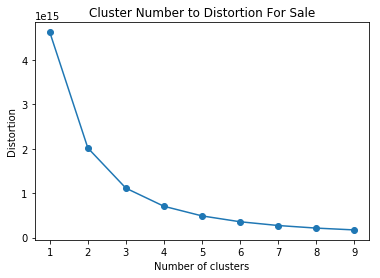

In [63]:
for_sale_res = run_k_mean(df_for_sale, 10, 'Cluster Number to Distortion For Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


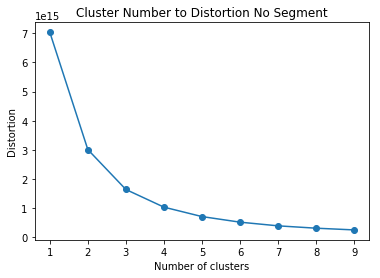

In [75]:
no_segment_res = run_k_mean(df_no_segment, 10, 'Cluster Number to Distortion No Segment')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


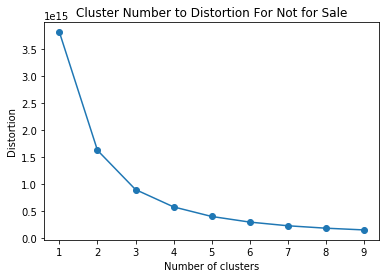

In [76]:
not_for_sale_res = run_k_mean(df_not_for_sale, 10, 'Cluster Number to Distortion For Not for Sale')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


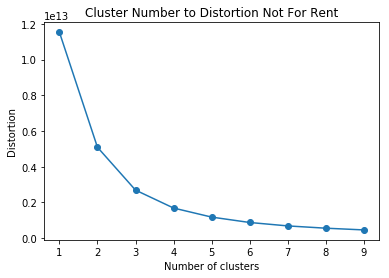

In [77]:
for_rent_res = run_k_mean(df_for_rent, 10, 'Cluster Number to Distortion Not For Rent')

In [78]:
normalized_for_sale_res_distortion = [i/max(for_sale_res[2]) for i in for_sale_res[2]]
print(normalized_for_sale_res_distortion)

[1.0, 0.43632633095921936, 0.24068227442508933, 0.1524423063629318, 0.10558180548207495, 0.07708555849378602, 0.0587974794506069, 0.04621099359512694, 0.037313681180338606]


In [79]:
normalized_no_segment_res_distortion = [i/max(no_segment_res[2]) for i in no_segment_res[2]]
print(normalized_no_segment_res_distortion)

[1.0, 0.4278719346892566, 0.23329310849449902, 0.14719401172830318, 0.10121791707284675, 0.07396793198396161, 0.056062287298283116, 0.04458425760099534, 0.036174737820834496]


In [83]:
normalized_not_for_sale_res_distortion = [i/max(not_for_sale_res[2]) for i in not_for_sale_res[2]]
print(normalized_not_for_sale_res_distortion)

[1.0, 0.4262439627040447, 0.23545218251837283, 0.1511975704514883, 0.10475708655885602, 0.07740150125216798, 0.05956245690046315, 0.047769041033674436, 0.03932340797432475]


In [84]:
normalized_for_rent_res_distortion = [i/max(for_rent_res[2]) for i in for_rent_res[2]]
print(normalized_for_rent_res_distortion)

[1.0, 0.4414101096735108, 0.23344016972096043, 0.14638784679633915, 0.1024414324528763, 0.07624971992522087, 0.05962872310135771, 0.04854579910472598, 0.04015288251707575]


## **Performance Summary of the Number of Clusters**

| Number of Clusters | For Sale Normalized Distortion | No Segment Normalized Distortion | Not For Sale Normalized Distortion | For Rent Normalized Distortion |
|------|------|------|------|------|
| 1  | 1 | 1 | 1 | 1 |
| 2  | 0.43 | 0.42 | 0.42  | 0.44 |
| 3  | 0.24 | 0.23 | 0.23 |  0.23 |
| 4  | 0.15 | 0.14 | 0.15 |  0.14 |
||||||
| **5**  | **0.10** | **0.10** | **0.10** |  **0.10** |
||||||
| 6  | 0.07 | 0.07 | 0.07 |  0.07 |
| 7  | 0.05 | 0.05 | 0.05 |  0.05 |
| 8  | 0.04 | 0.04 | 0.04 |  0.048|
| 9  | 0.03 | 0.03 | 0.03 |  0.041|

## Conclusions:
5 Clusters is a good number

## **More Insigth about the cluster = 5** 

In [13]:
# Initializing KMeans for 5 Clusters
kmeans = KMeans(n_clusters=5, 
                init='random',
                n_init=10, 
                max_iter=300,
                tol=1e-04, 
                random_state=0,
                n_jobs=multiprocessing.cpu_count()-2 )

In [23]:
# Fitting with inputs
kmeans = kmeans.fit(df_for_sale)

In [24]:
# Predicting the clusters
labels = kmeans.predict(df_for_sale)
# Getting the cluster centers
C = kmeans.cluster_centers_

(5, 14)


In [42]:
### Try to plot scatter for the most uncorrelated attributes based on correlation matrix

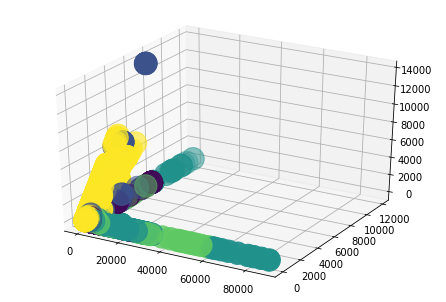

In [48]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_for_sale[df_for_sale.columns[0]], df_for_sale[df_for_sale.columns[3]], df_for_sale[df_for_sale.columns[5]], c=labels, s=500, cmap='viridis')
ax.scatter(C[:, 0], C[:, 3], C[:, 5], s=50, c='black', alpha=0.5)

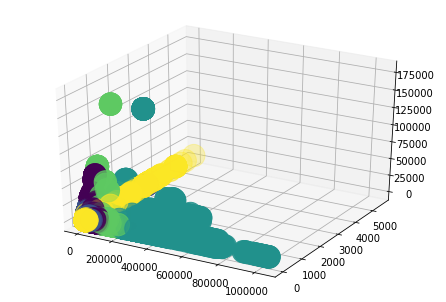

In [50]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_for_sale[df_for_sale.columns[4]], df_for_sale[df_for_sale.columns[6]], df_for_sale[df_for_sale.columns[7]], c=labels, s=500, cmap='viridis')
ax.scatter(C[:, 4], C[:, 6], C[:, 7], s=50, c='black', alpha=0.5)